# Purpose
* Reproduce the example from [Harald Vöhringer's Config Enumerate in Pyro](https://haraldvohringer.com/blog/config-enumerate-in-pyro/)

## Pyro Example

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import torch
from tqdm import tqdm

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark

In [3]:
%watermark -v -m -p matplotlib,numpy,pyro,torch,tqdm

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

matplotlib: 3.4.3
numpy     : 1.20.3
pyro      : 1.7.0
torch     : 1.9.0
tqdm      : 4.62.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.193-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [4]:
%watermark -gb

Git hash: 91ac69347112784797796c5a0c5c69b4eefb1fdc

Git branch: master



In [5]:
def sample(n=1):
    urn = pyro.distributions.Categorical(torch.ones(10) / 10).sample()
    draws = pyro.distributions.Binomial(10, urn / 10).sample((n,))
    return urn, draws

In [6]:
true_urn, draws = sample(10)
print(f"{true_urn=} | {draws=}")

true_urn=tensor(8) | draws=tensor([ 8.,  8., 10.,  6.,  7., 10.,  8.,  9.,  8.,  6.])


In [7]:
@pyro.infer.config_enumerate
def model(y):
    u = pyro.sample("u", pyro.distributions.Dirichlet(torch.ones(10)))
    with pyro.plate("data", y.shape[0]):
        urn = pyro.sample("urn", pyro.distributions.Categorical(u))
        pyro.sample("obs", pyro.distributions.Binomial(10, urn / 10), obs=y)


guide = pyro.infer.autoguide.AutoDiagonalNormal(pyro.poutine.block(model, expose=["u"]))

In [8]:
loss = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)

In [9]:
pyro.clear_param_store()
adam = pyro.optim.Adam({"lr": 0.001})
svi = pyro.infer.SVI(model, guide, adam, loss)
num_steps = 10000
losses = []
for _ in tqdm(range(num_steps)):
    loss = svi.step(draws)
    losses.append(loss)

100%|██████████| 10000/10000 [01:09<00:00, 143.28it/s]


[Text(0, 0.5, 'ELBO'), Text(0.5, 0, 'Step')]

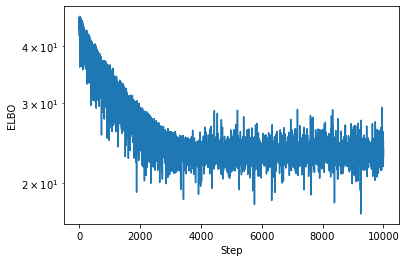

In [10]:
plt.semilogy(losses)
ax = plt.gca()
ax.set(ylabel="ELBO", xlabel="Step")

In [11]:
posterior = pyro.infer.Predictive(model, guide=guide, num_samples=5000)
params = posterior(draws)
posterior_u = params["u"].detach().numpy()

In [12]:
print(f"{true_urn=} | {draws=}")

true_urn=tensor(8) | draws=tensor([ 8.,  8., 10.,  6.,  7., 10.,  8.,  9.,  8.,  6.])


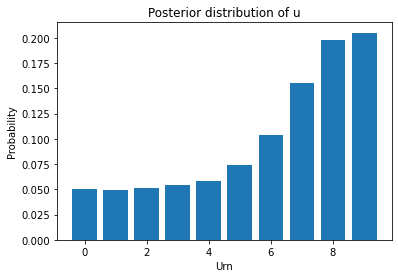

In [13]:
plt.bar(np.arange(10), posterior_u.mean(0).reshape(-1))
_ = plt.gca().set(
    xlabel="Urn", ylabel="Probability", title="Posterior distribution of u"
)

## NumPyro Example

In [14]:
import arviz as az
import jax
import jax.numpy as jnp
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [15]:
%watermark -v -m -p arviz,jax,pandas,numpyro

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

arviz  : 0.11.2
jax    : 0.2.19
pandas : 1.3.2
numpyro: 0.7.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.193-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [16]:
key = jax.random.PRNGKey(0)
key, key_split = jax.random.split(key)
key_split, key_split_split = jax.random.split(key_split)

In [17]:
def sample(n, key):
    urn = dist.Categorical(jnp.ones(10) / 10).sample(key)
    draws = dist.Binomial(10, urn / 10).sample(key, (n,))
    return urn, draws

In [18]:
true_urn, draws = sample(10, key_split_split)
print(f"{true_urn=} | {draws=}")

true_urn=DeviceArray(8, dtype=int32) | draws=DeviceArray([ 7,  5,  9,  8,  7,  7,  8,  8, 10,  7], dtype=int32)


In [19]:
def model(y):
    u = numpyro.sample("u", dist.Dirichlet(jnp.ones(10)))
    with numpyro.plate("data", y.shape[0]):
        urn = numpyro.sample("urn", dist.Categorical(u))
        numpyro.sample("obs", dist.Binomial(10, urn / 10), obs=y)

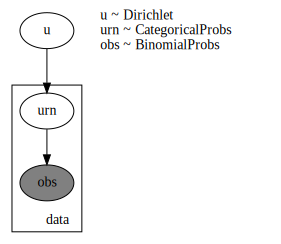

In [20]:
numpyro.render_model(model, (draws,), render_distributions=True)

In [21]:
nuts_kernel = NUTS(model)
num_chains, num_samples = 4, 1000
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=num_samples, num_chains=num_chains)
mcmc.run(key, draws, extra_fields=("potential_energy",))

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 5200.96it/s, 7 steps of size 4.77e-01. acc. prob=0.90]


In [22]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      u[0]      0.05      0.05      0.04      0.00      0.11   4779.24      1.00
      u[1]      0.05      0.05      0.04      0.00      0.11   6593.98      1.00
      u[2]      0.05      0.05      0.04      0.00      0.12   5305.45      1.00
      u[3]      0.05      0.05      0.04      0.00      0.12   5015.73      1.00
      u[4]      0.06      0.06      0.05      0.00      0.14   5680.06      1.00
      u[5]      0.08      0.07      0.06      0.00      0.18   4587.71      1.00
      u[6]      0.12      0.10      0.09      0.00      0.26   4743.49      1.00
      u[7]      0.18      0.14      0.15      0.00      0.40   4837.58      1.00
      u[8]      0.21      0.15      0.19      0.00      0.43   4176.28      1.00
      u[9]      0.14      0.10      0.11      0.00      0.28   5981.70      1.00

Number of divergences: 0


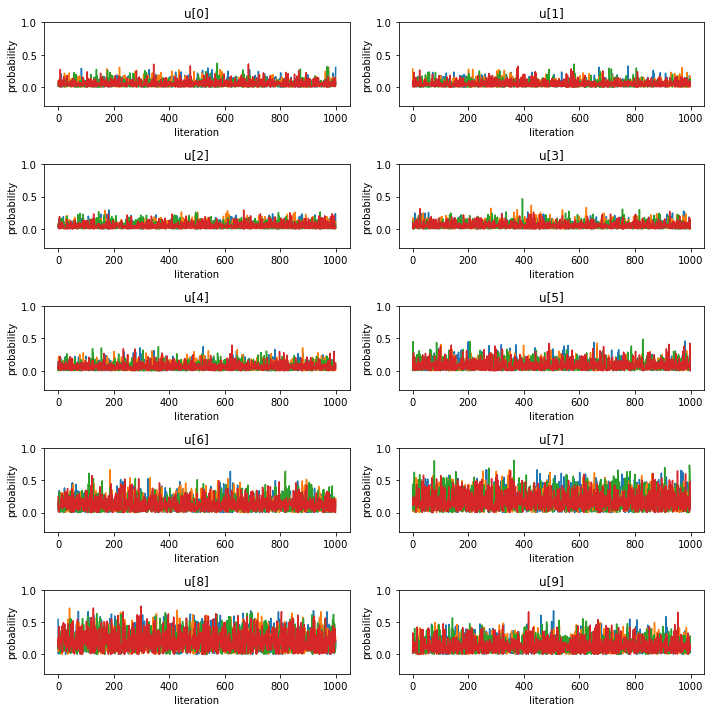

In [23]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    for row in mcmc.get_samples()["u"][:, i].reshape((num_chains, num_samples)):
        ax.set_ylim((-0.3, 1.0))
        ax.set_ylabel("probability")
        ax.set_xlabel("Iiteration")
        ax.plot(row)
        ax.set_title(f"u[{i}]")

fig.tight_layout()
plt.show()

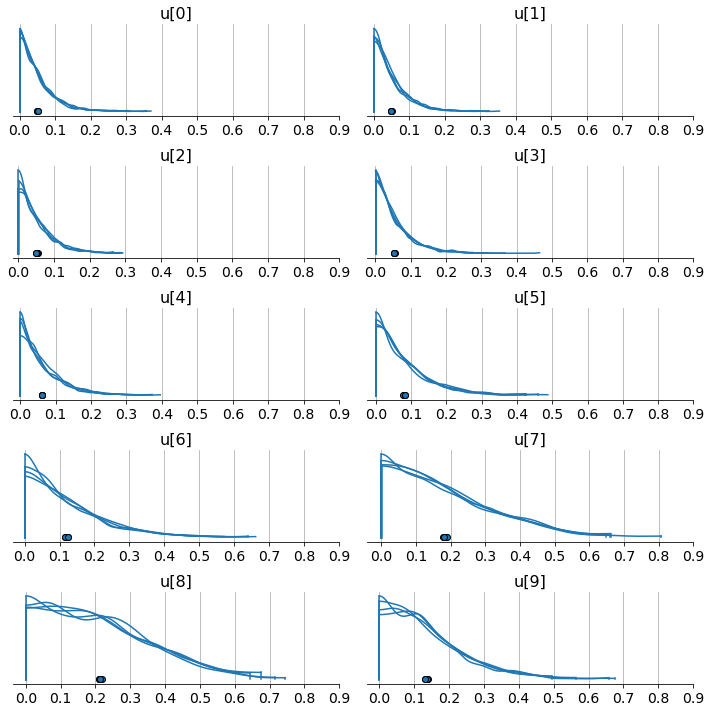

In [24]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    for row in mcmc.get_samples()["u"][:, i].reshape((num_chains, num_samples)):
        az.plot_density({"u[{}]".format(i): row}, hdi_prob=1, ax=ax)
        ax.set_xticks(np.arange(0, 1, 0.1))
        ax.grid(True)

fig.tight_layout()
plt.show()

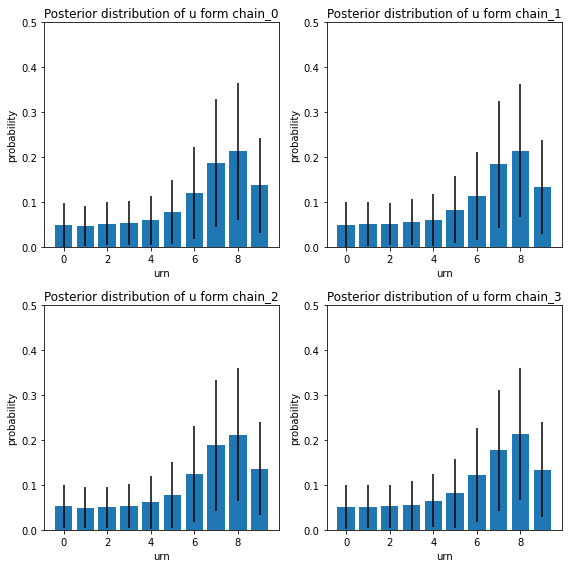

In [25]:
# https://stackoverflow.com/a/39622821/3587374
trace_mean = (
    mcmc.get_samples()["u"]
    .reshape(
        mcmc.get_samples()["u"].shape[0] // num_chains,
        -1,
        mcmc.get_samples()["u"].shape[1],
    )
    .mean(axis=0)
)
trace_std = (
    mcmc.get_samples()["u"]
    .reshape(
        mcmc.get_samples()["u"].shape[0] // num_chains,
        -1,
        mcmc.get_samples()["u"].shape[1],
    )
    .std(axis=0)
)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axes.flatten()):
    ax.bar(np.arange(10), trace_mean[i].reshape(-1), yerr=trace_std[i].reshape(-1))
    ax.set_ylim((0, 0.5))
    ax.set_ylabel("probability")
    ax.set_xlabel("urn")
    ax.set_title(f"Posterior distribution of u form chain_{i}")

fig.tight_layout()
plt.show()

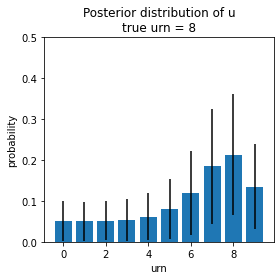

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(
    np.arange(10),
    mcmc.get_samples()["u"].mean(axis=0).reshape(-1),
    yerr=mcmc.get_samples()["u"].std(axis=0).reshape(-1),
)
ax.set_ylim((0, 0.5))
ax.set_ylabel("probability")
ax.set_xlabel("urn")
ax.set_title(f"Posterior distribution of u\ntrue urn = {true_urn.item()}")
fig.tight_layout()
plt.show()